# **Lab3 : Image Segmentation (Histogram of Oriented Gradients & K-Mean Clustering)**

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import measure, feature

import glob

from sklearn.cluster import KMeans

from scipy import spatial

from tqdm import tqdm
import cv2
import os
import random

## Load Image

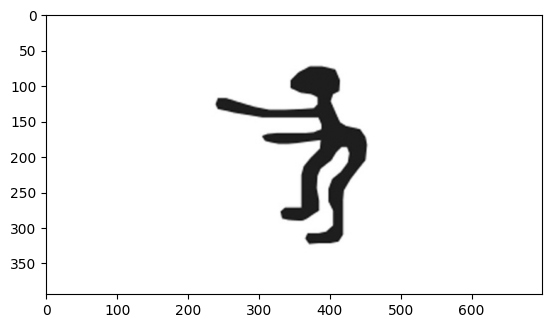

In [2]:
### START CODE HERE ###
image = plt.imread("./asset/stickman.png")
plt.imshow(image, cmap="gray")
### END CODE HERE ###

## Histogram of Oriented Gradients

Blur the image then apply to the [`hog()`](<https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.hog:~:text=skimage.feature.hog(,%23>)
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/1.png?raw=true)
</details>

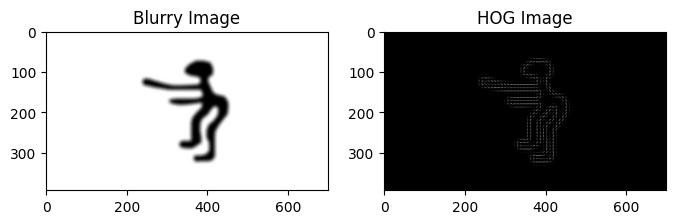

In [3]:
### START CODE HERE ###
blurry_image = cv2.GaussianBlur(image, (15, 15), 5)
fd, hog_image = hog(blurry_image, visualize=True)

plt.figure(figsize=(8, 4))

plt.subplot(1, 2, 1)
plt.imshow(blurry_image, cmap="gray")
plt.title('Blurry Image')

plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap=plt.cm.gray)
plt.title('HOG Image')

plt.show()

### END CODE HERE ###

Complete the `HOGSubimageExtractor()`.

That extracts Histogram of Oriented Gradients features from sub-images of a larger image. It divides the image into overlapping tiles, computes HOG features for each tile, and stores both the feature vectors and visualizations. The class also provides a method to plot the HOG visualizations.

**Attributes:**
- `image`: The input image.
- `tile_size`: The size of each sub-image to extract.
- `stride`: The pixel stride between consecutive sub-images.
- `hGrid`: An array of indices representing the starting positions for rows of sub-images.
- `wGrid`: An array of indices representing the starting positions for columns of sub-images.
- `hog_features`: A list to store the HOG feature vectors for each sub-image.
- `hog_images`: A list to store the visualized HOG images for each sub-image (optional).

**Methods:**
- `extract_hog_features()`: Compute HOG features for each sub-image.
- `plot_hog_images()`: Plots the HOG visualization images.
- `get_num_grid()`: Return the number of rows and columns in the grid of sub-images.


In [4]:
class HOGSubimageExtractor:
    def __init__(self, image, tile_size, stride, padding=2):
        self.image = image
        self.tile_size = tile_size
        self.stride = stride
        self.padding = padding  # ช่องว่างระหว่างภาพย่อย
        self.hog_features = []
        self.hog_images = []
        self.hGrid, self.wGrid = self._create_grid()
        self.extract_hog_features()
        self.image_shape = image.shape  # ขนาดของภาพต้นฉบับ

    def _create_grid(self):
        """ สร้างกริดสำหรับแถวและคอลัมน์ของภาพย่อย """
        h, w = self.image.shape[:2]
        hGrid = np.arange(0, h - self.tile_size + 1, self.stride)
        wGrid = np.arange(0, w - self.tile_size + 1, self.stride)
        return hGrid, wGrid

    def extract_hog_features(self):
        """ คำนวณ HOG สำหรับภาพย่อยแต่ละภาพในภาพใหญ่ """
        for i in self.hGrid:
            for j in self.wGrid:
                # ตัดภาพย่อยจากภาพใหญ่
                sub_image = self.image[i:i + self.tile_size, j:j + self.tile_size]

                # คำนวณคุณสมบัติ HOG สำหรับภาพย่อย
                features, hog_image = hog(sub_image, pixels_per_cell=(4, 4), cells_per_block=(2, 2), visualize=True)

                # เก็บ HOG features และภาพ HOG visualization
                self.hog_features.append(features)
                self.hog_images.append(hog_image)
        # print(self.hog_features)
        # print(type(self.hog_features))

    def plot_hog_images(self):
        """ แสดงภาพ HOG visualization โดยต่อภาพย่อยหลาย ๆ ภาพในรูปแบบสี่เหลี่ยมจัตุรัส """
        # คำนวณขนาดของกริด
        num_rows = len(self.hGrid)
        num_cols = len(self.wGrid)

        # ขนาดของแต่ละภาพ HOG ที่แสดง
        tile_height, tile_width = self.hog_images[0].shape

        # ขนาดของภาพรวม (เพิ่มระยะห่างระหว่างภาพย่อย)
        combined_image_height = num_rows * tile_height + (num_rows - 1) * self.padding
        combined_image_width = num_cols * tile_width + (num_cols - 1) * self.padding

        # สร้างภาพที่มีขนาดใหญ่พอที่จะรองรับภาพย่อยทั้งหมดพร้อมช่องว่าง
        combined_image = np.zeros((combined_image_height, combined_image_width))

        # ต่อภาพ HOG ทั้งหมดเข้าด้วยกันพร้อมช่องว่าง
        for i in range(num_rows):
            for j in range(num_cols):
                index = i * num_cols + j
                start_row = i * (tile_height + self.padding)
                start_col = j * (tile_width + self.padding)

                # ตำแหน่งที่ใช้สำหรับต่อภาพ
                combined_image[start_row:start_row + tile_height, start_col:start_col + tile_width] = self.hog_images[index]

        # กำหนดขนาดของภาพที่จะแสดง
        plt.figure(figsize=(16, 16))  # เพิ่มขนาดภาพ (สามารถปรับให้ใหญ่ขึ้นตามต้องการ)

        # แสดงภาพที่ต่อแล้ว
        plt.imshow(combined_image, cmap=plt.cm.gray)
        plt.axis('off')  # ซ่อนแกน
        plt.show()

    def get_num_grid(self):
        """ ส่งคืนจำนวนแถวและคอลัมน์ในกริดของภาพย่อย """
        return len(self.hGrid), len(self.wGrid)


Let's use `HOGSubimageExtractor()` in the cell below.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output from hog_extractor.plot_hog_images()</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/2.png)
</details>

Number of grids: (49, 87)


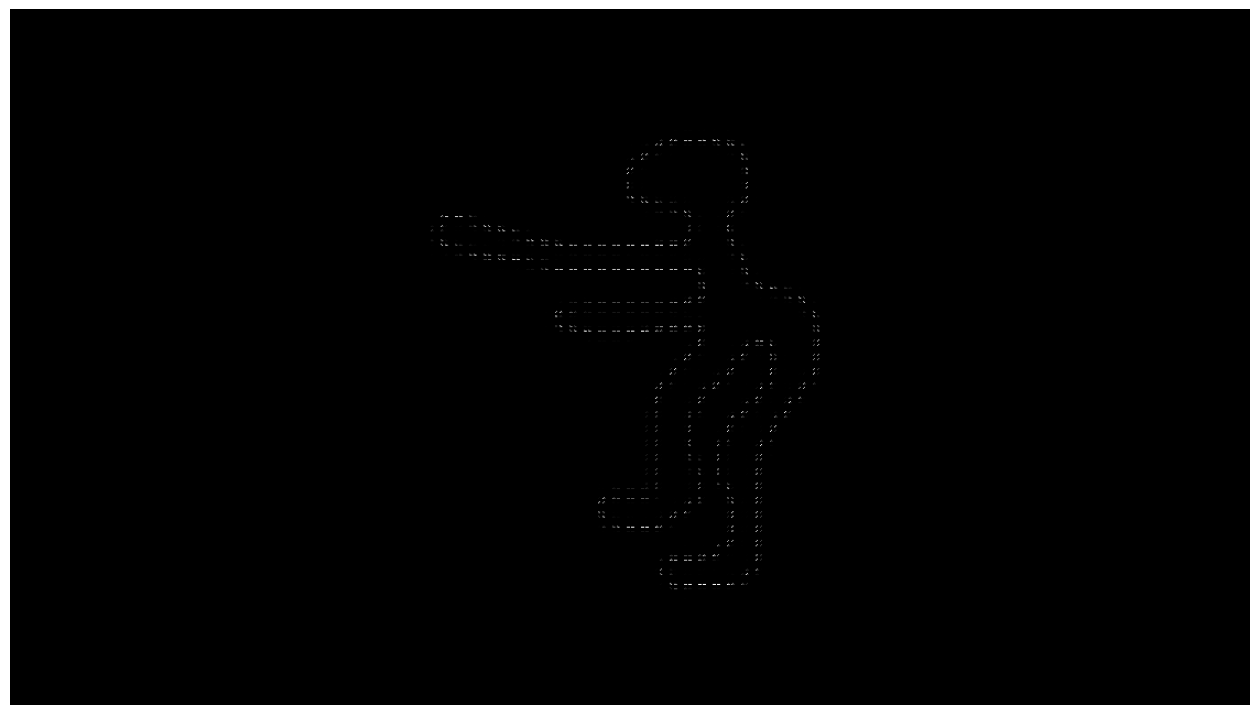

In [24]:
extractor = HOGSubimageExtractor(image, tile_size=8, stride=8, padding=5)

num_grid = extractor.get_num_grid()
print(f'Number of grids: {num_grid}')

extractor.plot_hog_images()

## K-Mean Clustering
Complete the `KMeansCluster()`.
Perform K-means clustering on Histogram of Oriented Gradients (HOG) features extracted from an image.
**Attriburtes:**
- `hog_extractor`: An object responsible for extractin HOG features from an image.
- `n_clusters`: The number of clusters to use in K-means.
- `cluster_array`: A 2D array representing the cluster assignments for each grid cell.
- `all_labels`: A 2D array representing the connected components (objects) identified after clustering.
- `bounding_boxes`: A list of tuples containing (object_id, start_coordinates, end_coordinates) for each detected object.

**Method:**
- `perform_clustering()`: Performs K-means clustering on the HOG features extracted by the hog_extractor object.<br>
It then reshapes the cluster assignmentss into a grid and identifies connected components using the `measure.label()` function.
- `plot_cluster_and_labels()`: Visualize the cluster assignments and connected components as images using Matplotlib.
- `get_bounding_boxes()`: Extracts bounding boxes for each detected object.

In [6]:
class KMeansCluster:
    def __init__(self, hog_extractor, n_clusters, random_state):
        self.hog_extractor = hog_extractor
        self.n_clusters = n_clusters
        self.random_state = random_state
        self.cluster_array = None
        self.all_labels = None
        self.bounding_boxes = []
        self.perform_clustering()

    def perform_clustering(self):
        hog_features = np.array(self.hog_extractor.hog_features)
        kmeans = KMeans(n_clusters=self.n_clusters, random_state=self.random_state)
        kmeans.fit(hog_features)
        self.cluster_array = kmeans.labels_.reshape(self.hog_extractor.get_num_grid())
        self.all_labels = measure.label(self.cluster_array, connectivity=2)

        print("hog_features shape:", hog_features.shape)
        print("Grid shape:", self.hog_extractor.get_num_grid())
        print("cluster_array shape:", self.cluster_array.shape)
        print("Unique cluster labels:", np.unique(self.cluster_array))
        print("Unique connected component labels:", np.unique(self.all_labels))

    def plot_cluster_and_labels(self):
        fig, ax = plt.subplots(1, 2, figsize=(12, 6))
        ax[0].imshow(image, cmap='gray')
        ax[0].set_title('Original Image')
        ax[0].axis('off')

        img = ax[1].imshow(self.cluster_array)
        ax[1].set_title('KMeans Cluster')
        ax[1].axis('off')
        # ax[1].imshow(self.all_labels, cmap='nipy_spectral')
        # ax[1].set_title('Connected Components')
        # ax[1].axis('off')
        plt.colorbar(img)
        plt.tight_layout()
        plt.show()

    def get_bounding_boxes(self):
        self.bounding_boxes = []
        h_num, w_num = self.hog_extractor.get_num_grid()
        tile_h, tile_w = self.hog_extractor.tile_size, self.hog_extractor.tile_size
        for region in measure.regionprops(self.all_labels):
            minr, minc, maxr, maxc = region.bbox
            x = minc * tile_w
            y = minr * tile_h
            w = (maxc - minc) * tile_w
            h = (maxr - minr) * tile_h
            self.bounding_boxes.append((x, y, w, h))
        return self.bounding_boxes
### END CODE HERE ###

In [7]:
def draw_bbox(image, bboxes):
    img = image.copy()
    for bbox in bboxes:
        x, y, w, h = bbox
        cv2.rectangle(img, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)
    
    # plt.scatter(448, 112, color='red', s=100)

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img_rgb)
    plt.axis('off')
    plt.show()

Let's use `KMeansCluster()` and `draw_bbox()` in the cell below.
<details>

<summary>
<font size="3" color="orange">
<b>Expected output</b>
</font>
</summary>

- The output should resemble this, but not be identical

![image-3.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/3.png?raw=true)

![image-4.png](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/4.png?raw=true)
</details>

hog_features shape: (4263, 36)
Grid shape: (49, 87)
cluster_array shape: (49, 87)
Unique cluster labels: [0 1]
Unique connected component labels: [0 1]


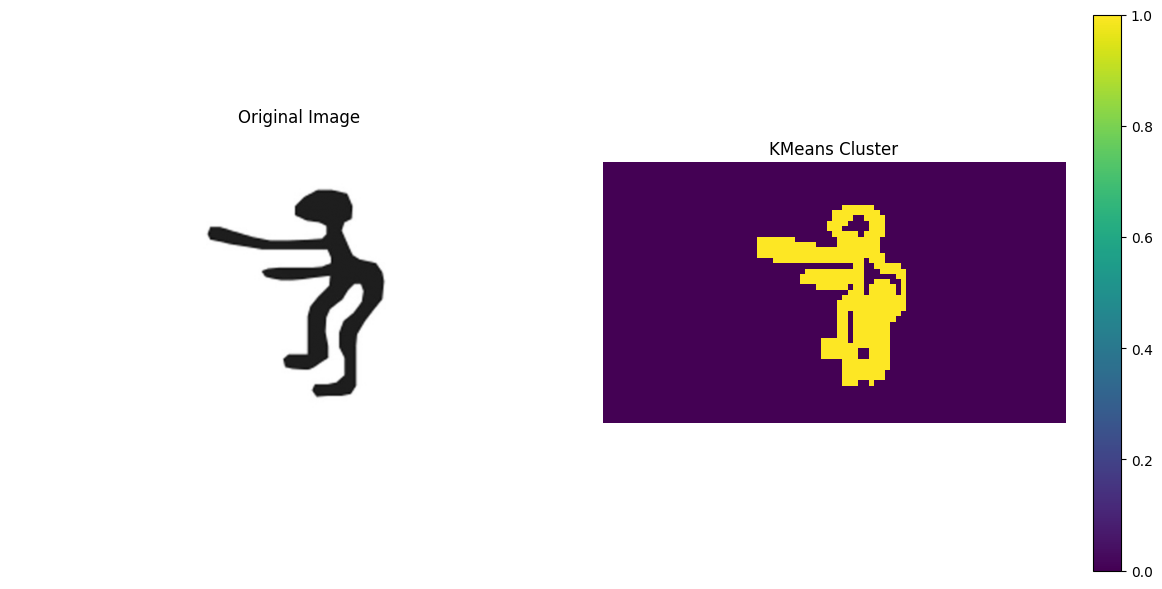

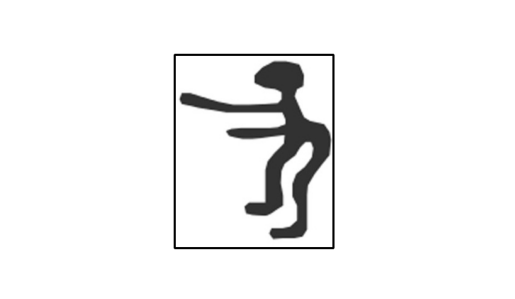

In [25]:
kmeans_cluster = KMeansCluster(extractor, 2, 42)
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.get_bounding_boxes()
draw_bbox(image, bboxes)

---

## Experiment
Do the experiment to identify 3 best parameters that produce the perfectly fitting bounding box of the object of interest in the image.

Number of grids: (49, 87)


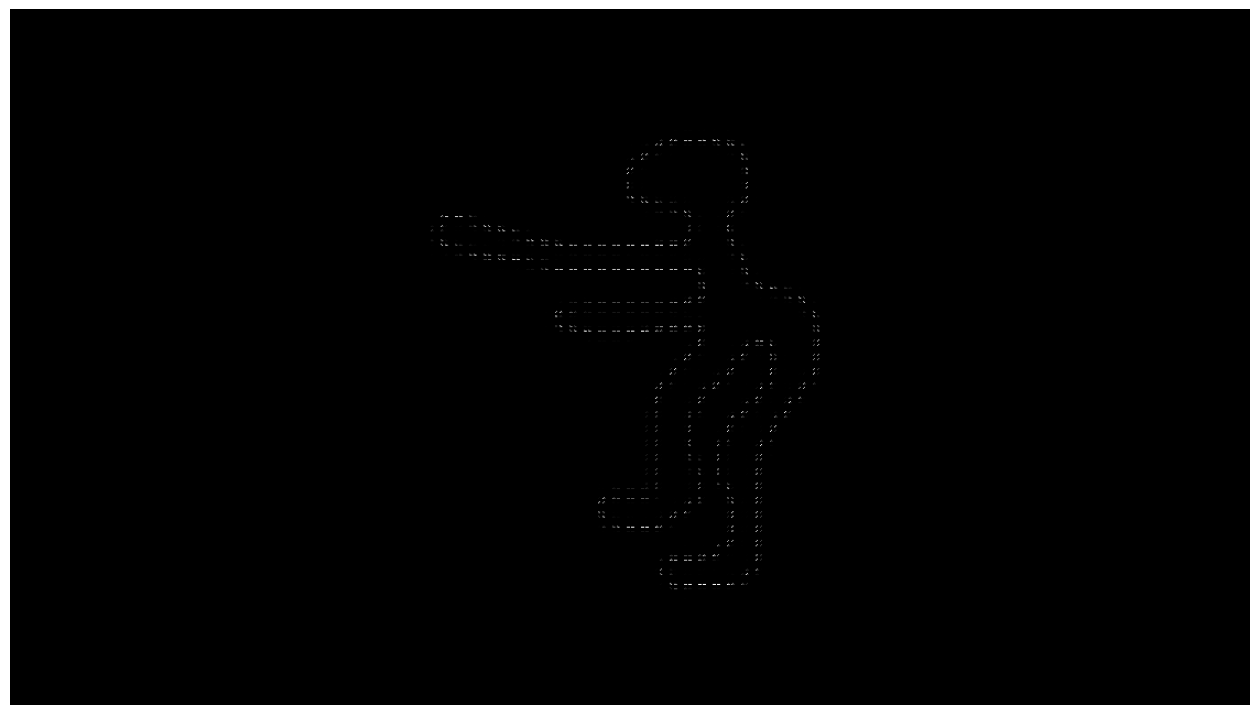

hog_features shape: (4263, 36)
Grid shape: (49, 87)
cluster_array shape: (49, 87)
Unique cluster labels: [0 1]
Unique connected component labels: [0 1]


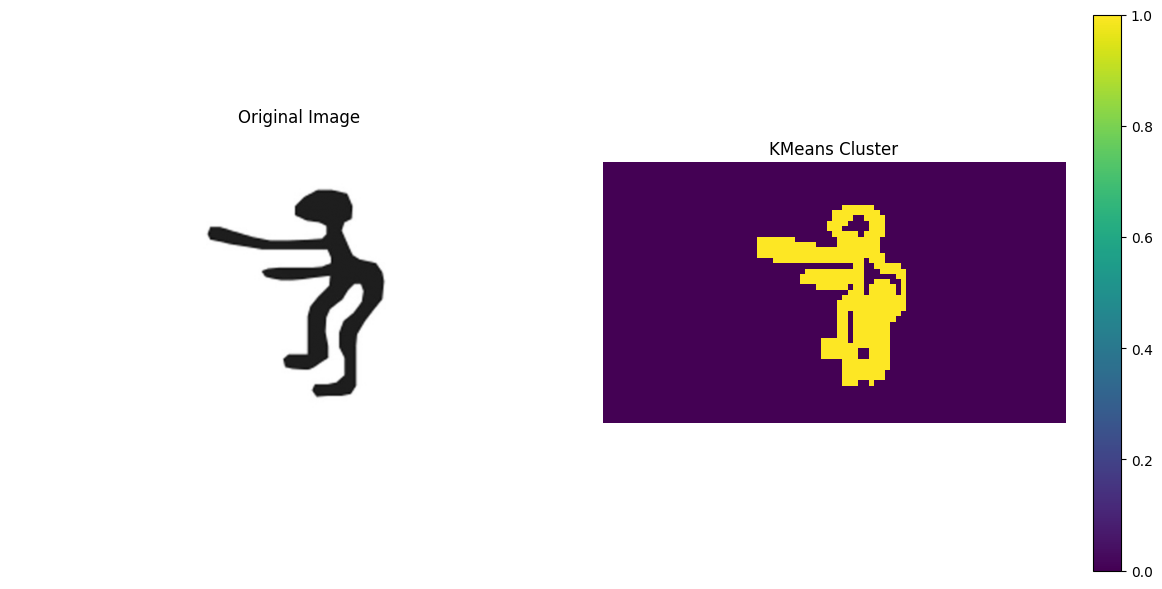

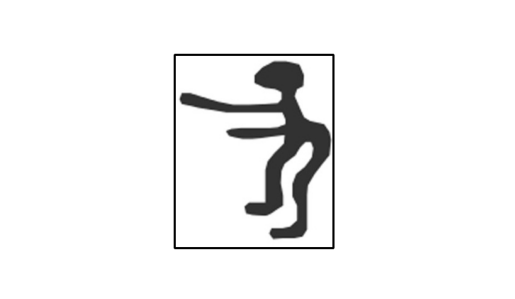

In [21]:
### START CODE HERE ###

tile_size = 8
stride = 8

extractor = HOGSubimageExtractor(image, tile_size=tile_size, stride=stride, padding=5)

num_grid = extractor.get_num_grid()
print(f'Number of grids: {num_grid}')

extractor.plot_hog_images()

kmeans_cluster = KMeansCluster(extractor, 2, 42)
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.get_bounding_boxes()
draw_bbox(image, bboxes)

### END CODE HERE ###

Number of grids: (12, 21)


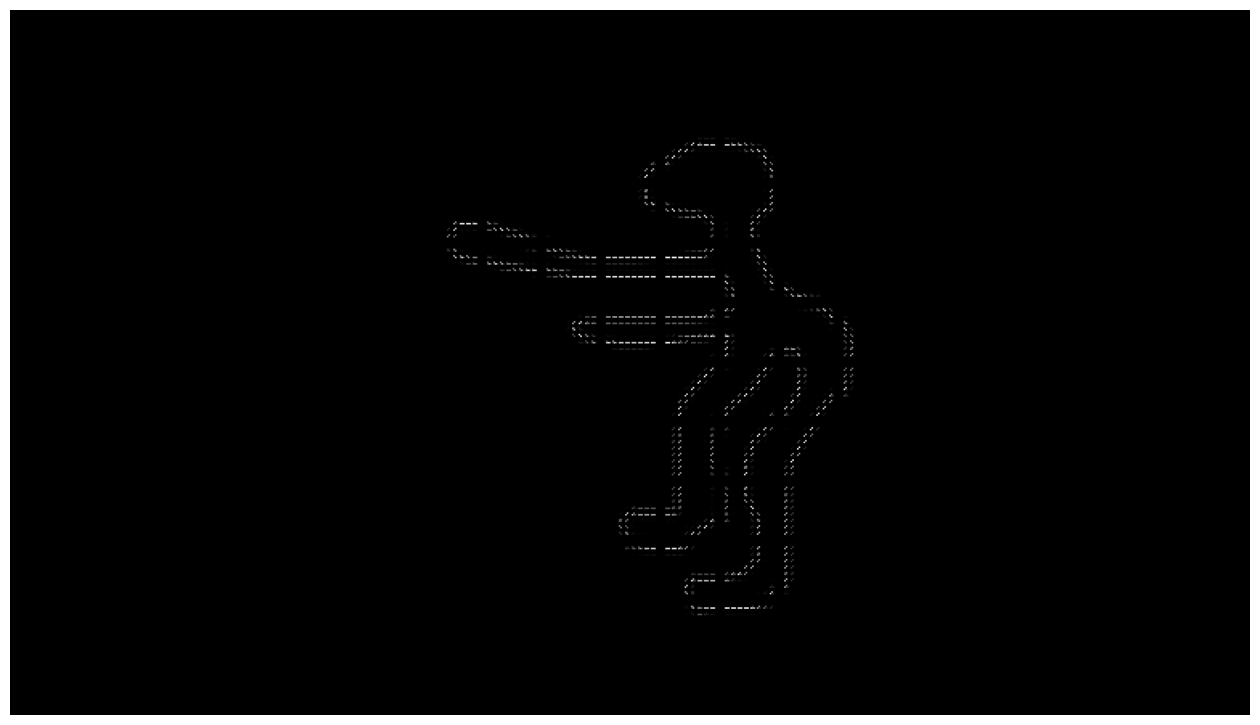

hog_features shape: (252, 1764)
Grid shape: (12, 21)
cluster_array shape: (12, 21)
Unique cluster labels: [0 1]
Unique connected component labels: [0 1]


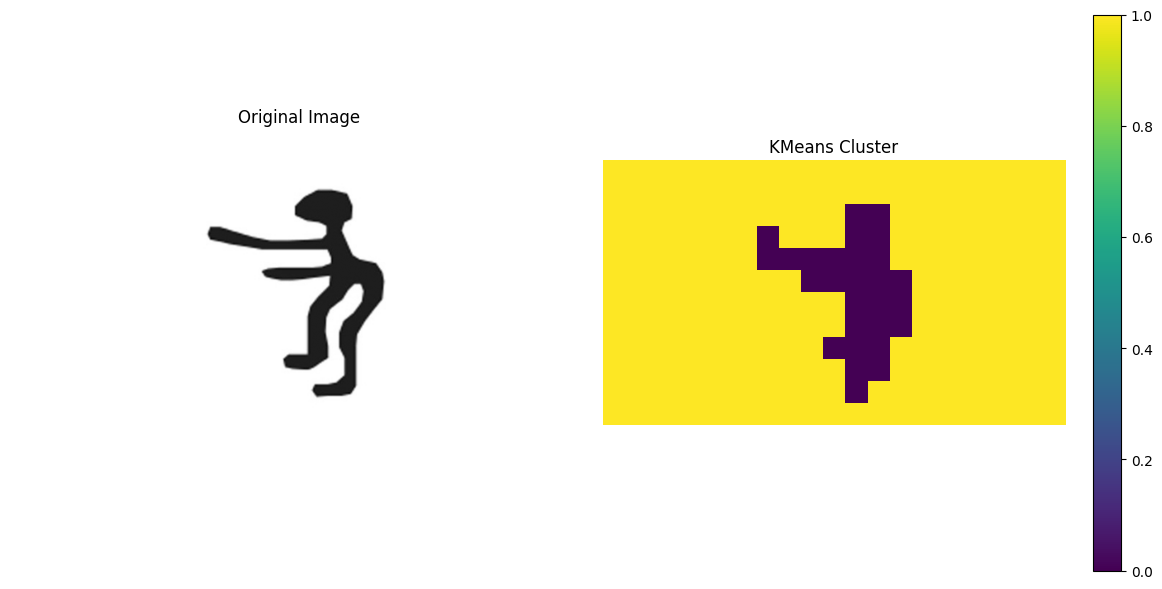

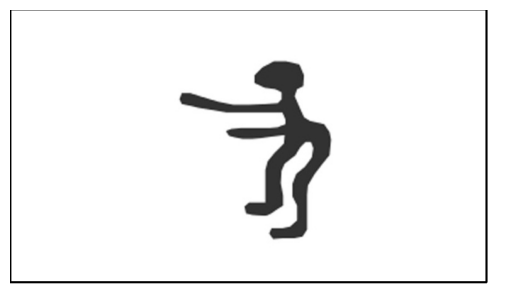

In [17]:
### START CODE HERE ###

tile_size = 32
stride = 32

extractor = HOGSubimageExtractor(image, tile_size=tile_size, stride=stride, padding=5)

num_grid = extractor.get_num_grid()
print(f'Number of grids: {num_grid}')

extractor.plot_hog_images()

kmeans_cluster = KMeansCluster(extractor, 2, 42)
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.get_bounding_boxes()
draw_bbox(image, bboxes)

### END CODE HERE ###

Number of grids: (6, 10)


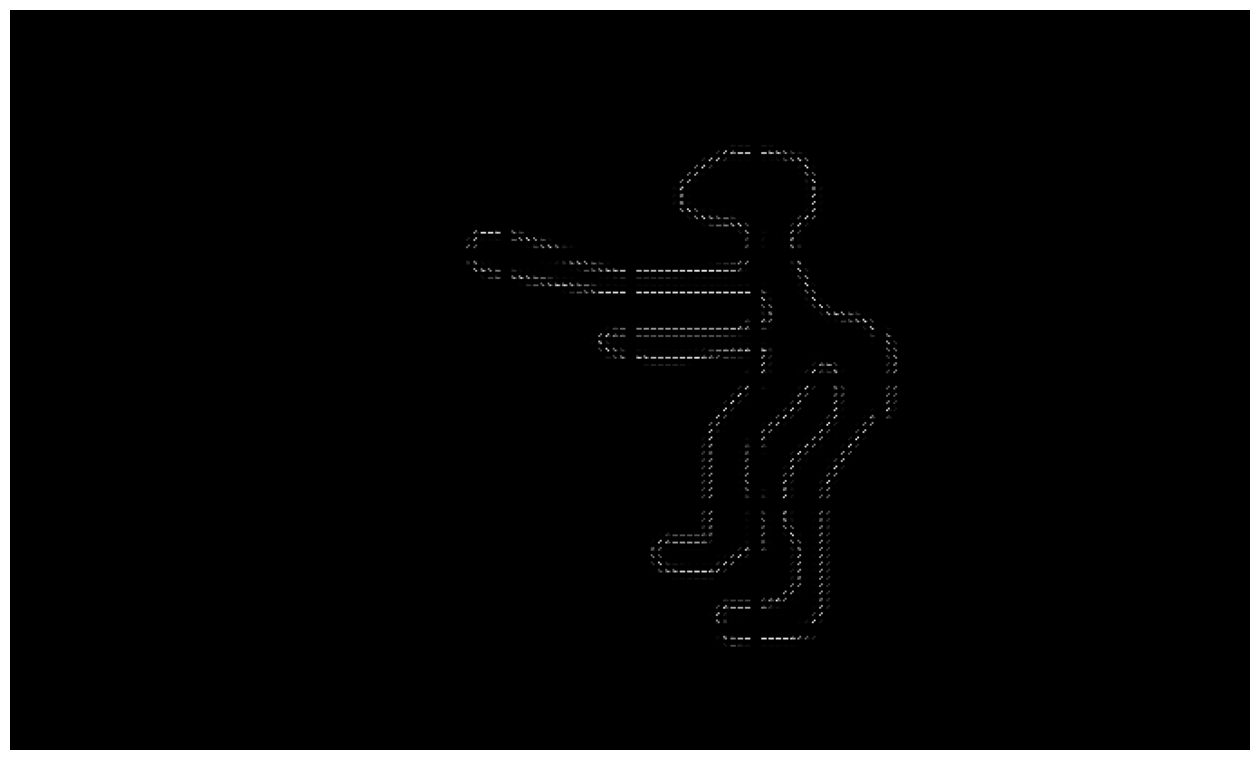

hog_features shape: (60, 8100)
Grid shape: (6, 10)
cluster_array shape: (6, 10)
Unique cluster labels: [0 1]
Unique connected component labels: [0 1]


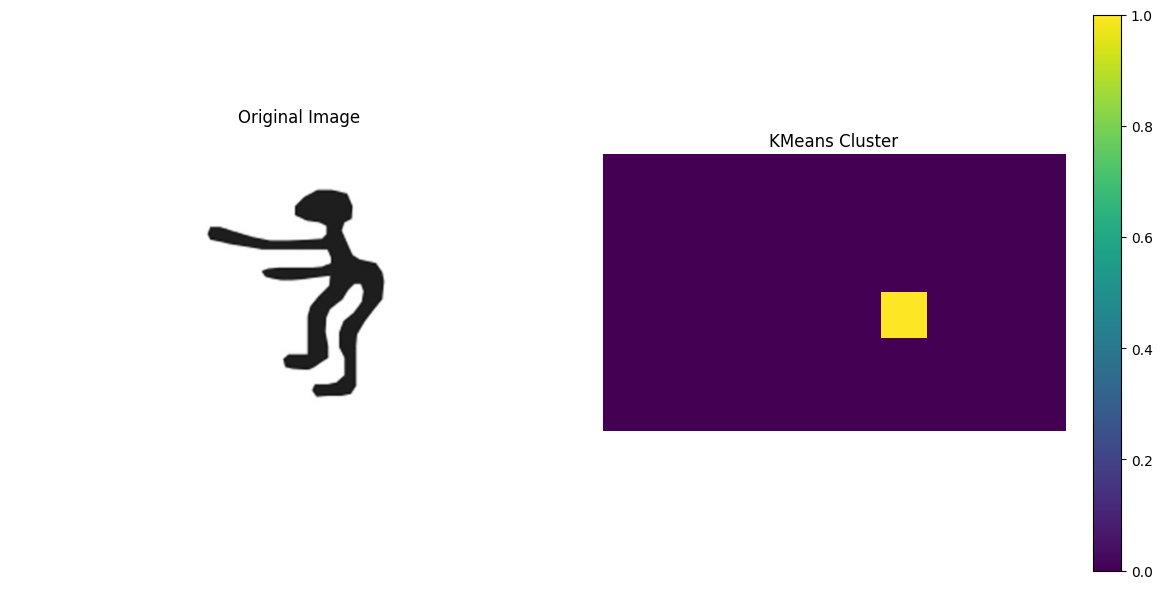

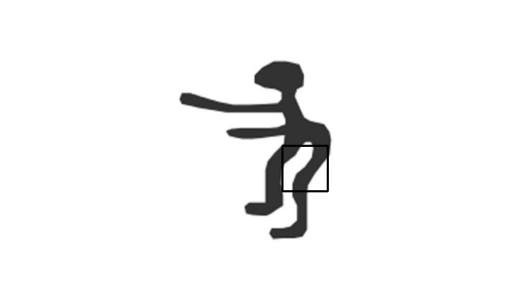

In [16]:
### START CODE HERE ###

tile_size = 64
stride = 64

extractor = HOGSubimageExtractor(image, tile_size=tile_size, stride=stride, padding=5)

num_grid = extractor.get_num_grid()
print(f'Number of grids: {num_grid}')

extractor.plot_hog_images()

kmeans_cluster = KMeansCluster(extractor, 2, 42)
kmeans_cluster.plot_cluster_and_labels()
bboxes = kmeans_cluster.get_bounding_boxes()
draw_bbox(image, bboxes)

### END CODE HERE ###

---

## **Question** 
1. How do the parameters of Gaussian blur, such as kernel size and standard deviation, affect the image processing in the context of k-means clustering?

2. How do the configurations of cells per block and pixels per cell influence the effectiveness of object detection in an image?

3. What differences can be observed in the clustering results when using smaller sub-images (tiles) compared to larger ones?

4. What is the impact on object detection if the labeling step is skipped before applying k-means clustering?

5. How does the choice of the number of clusters (K) in k-means clustering affect the image clustering result (right) of an input image (left)? 
Discuss the trade-offs between too few and too many clusters in accurately representing the test patterns.<br>

![q5.jpg](https://raw.githubusercontent.com/Digital-Image-Processing-Laboratory/Image-Processing-Course-2025/refs/heads/main/Lab3_Image-Segmentation/asset/q5.jpg?raw=true)


1. ปกติการทำ Gaussian Blur จะเป็นการเบลอภาพ ทำให้ภาพเรียบขึ้น เช่น ลดความแตกต่างของสีระหว่างพิกเซลที่อยู่ติดกัน ทำให้ขอบเบลอลง ซึ่งถ้าค่าพารามิเตอร์เหล่านี้มากเกินไป ภาพก็จะเบลอจน K-means แยกความแตกต่างไม่ออก เพราะค่าของแต่ละพิกเซลใกล้เคียงกันไปหมด แต่ถ้าค่าน้อยไป K-means อาจจะจัดกลุ่มได้มากเกินไป เพราะค่าสีของแต่ละพิกเซลแตกต่างกันมากนั่นเอง
2. ค่า Pixels per Cell จะกำหนดว่า Cell นึงที่ขนาดเท่าไหร่ และถ้ายิ่ง Cell เล็กก็จะยิ่งเก็บทิศทางและรายละเอียดของภาพได้มาก ทำให้แยกวัตถุที่มีขนาดเล็กในภาพได้ดีขึ้น ขณะที่ค่า Cells per Block จะกำหนดว่า Block หนึ่งๆ จะรวบรวมข้อมูลจาก Cell ได้กี่อัน ถ้า Block ใหญ่ก็จะทำให้ได้ข้อมูลภาพรวมของขอบในพื้นที่ที่กว้างขึ้น ทำให้จับวะตถุอันใหญ่ได้ดีขึ้น แต่ถ้ามากไปตำแหน่งก็อาจจะไม่แม่นยำ
3. Tiles ขนาดเล็กจะดีกับการระบุวัตถุขนาดเล็ก และ Tiles ขนาดใหญ่จะดีกับการระบุวัตถุขนาดใหญ่ ในกรณที่เราใช้ Tiles ขนาดเล็กในการระบุวะตถุอันใหญ่ ก็อาจจะทำให้วัตถุถูกแบ่งเป็นหลายส่วนได้ ในขณะที่ถ้าใช้ Tiles ขนาดใหญ่แยกวัตถุอันเล็กๆก็ทำได้ไม่ดีนัก
4. เนื่องจาก K-means Clustering เป็นการจัดกลุ่มแบบ Unsupervised ไม่จำเป็นต้องมีขั้นตอนการ Labeling
5. ถ้าค่า K น้อยเกินไป ผลที่ได้ก็อาจจะรวมเอาส่วนของภาพที่จริงๆ แล้วควรจะแยกจากกันมาอยู่ในกลุ่มเดียวกัน เช่น ถ้าค่า K = 2 ก็อาจจะแยกได้แค่วัตถุกับพื้นหลังแบบง่ายๆ แต่ถ้าค่า K มากเกินไป ผลที่ออกมาก็อาจจะแบ่งส่วนของภาพที่จริงๆแล้วควรจะอยู่ในกลุ่มเดียวกันให้เป็นกลุ่มย่อยๆหลายกลุ่ม อาจจับ Noise หรือความแตกต่างที่ไม่สำคัญมาเป็นกลุ่มใหม่ แต่ว่าอาจเป็นประโยชน์ในกรณีที่มีความละเอียดสูง